# NLP. word2vec embeddings

In this notebook I will delve into CBOW and Skip-gram.

I will use `imdb_reviews` dataset.

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import torch
import re
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from statistics import median


np.random.seed(42)
torch.manual_seed(42)

In [ ]:
imdb_train = tfds.load('imdb_reviews/plain_text', split='train', shuffle_files=True)
imdb_train = tfds.as_dataframe(imdb_train)
print(imdb_train.head())

imdb_train_x = np.array([s.decode('utf-8') for s in imdb_train['text'].tolist()])
imdb_train_y = imdb_train['label'].to_numpy()

print(f"imdb_reviews(split='train'): x={len(imdb_train_x)}, y={len(imdb_train_y)}")

   label                                               text
0      0  b"This was an absolutely terrible movie. Don't...
1      0  b'I have been known to fall asleep during film...
2      0  b'Mann photographs the Alberta Rocky Mountains...
3      1  b'This is the kind of film for a snowy Sunday ...
4      1  b'As others have mentioned, all the women that...
imdb_reviews(split='train'): x=25000, y=25000


## Data preprocess

Let's see how the data looks like:

In [ ]:
text = " ".join(imdb_train_x)
text[:100]

"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. "

### Text normalization

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')


def remove_punctuation(text):
    punct = r"[\d!\"#\$%&\'\(\)\*\+,-.\/:;<=>\?@\[\\\]\^_`{\|}~]"
    text = re.sub(punct, " ", text)
    return text


def remove_stopwords(text):
    text = " ".join([word for word in text.split(" ") if word not in stop_words])
    return text


def remove_space_symbols(text):
    text =  ' '.join(text.split())
    return text


def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    return text


def cleanup(text: str) -> str:
  text = text.lower()

  text = remove_html_tags(text)  # Should be called before removing punktuation, as the tags then won't be recognised by the library
  text = remove_space_symbols(text)  # Should be called before removing punktuation, as if we have such symbols as '\n', we need to preserve '\'
  text = remove_punctuation(text)
  text = remove_space_symbols(text)  # One more time, as we've replaced punctuation symbols with spaces
  text = remove_stopwords(text)

  return text


def tokenize(text):
  return list(set(text.split()))


def drop_rare(text):
  """
  The words with frequency 1 are too rare and are probably misprints.
  """

  list_of_words = text.split(" ")
  frequencies = Counter(list_of_words)
  list_of_words = [w for w in list_of_words if frequencies[w] > 1]
  return " ".join(list_of_words)


text = cleanup(text)
print(f"Unique words before deleting rare: {len(set(text.split(" ")))}")
text = drop_rare(text)
print(f"Unique words after deleting rare: {len(set(text.split(" ")))}")

vocab = ['<PAD>']
vocab.extend(tokenize(text))
vocab.append("<UNK>")
print("Example of words from vocab: ", vocab[:5])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Unique words before deleting rare: 74955
Unique words after deleting rare: 46326
Example of words from vocab:  ['<PAD>', 'hissy', 'schneider', 'frisco', 'flint']


### Creating a vocabulary

In [ ]:
def vocab_to_int(vocab):
  vocab_to_int = {}
  for i, word in enumerate(vocab):
    vocab_to_int[word] = i
  return vocab_to_int

vocab_to_int = vocab_to_int(vocab)

In [ ]:
def to_ints(data):
  ints = []

  for chunk in data:
    if isinstance(chunk, str):
      # data is plain text
      word = chunk

      if word in vocab_to_int:
        ints.append(vocab_to_int[word])
      else:
        ints.append(vocab_to_int["<UNK>"])

    else:
      # data is a list of contexts
      context = chunk

      context_ints = []
      for word in context:
        if word in vocab_to_int:
          context_ints.append(vocab_to_int[word])
        else:
          context_ints.append(vocab_to_int["<UNK>"])
      ints.append(context_ints)

  return ints

text_ints = to_ints(text.split())
print(f"This text: '{" ".join(text.split(" ")[:5])}' turns into this sequence: {text_ints[:5]}")

This text: 'absolutely terrible movie lured christopher' turns into this sequence: [29926, 28162, 39300, 43725, 30302]


Now we have prepared everything for creating dataloaders. We have:
- `text` - a long string with all text from the dataset
- `text_ints` - the same as textm but all words are now encoded as ints
- `vocab` - vocabulary of all words used to convert ints to words
- `vocab_to_int` - vocabulary with all words used to convert words to ints

In the following cell we will transform the data to (features, target) pairs and create dataloaders.

### Preparing pairs (fearutes, target)

In [ ]:
def get_context_with_centre(text_list, w):
  contexts = []
  centres = []

  for i in range(w, len(text_list)-w):
    context = text_list[i-w:i] + text_list[i+1:i+1+w]
    contexts.append(context)

    centres.append(text_list[i])

  return contexts, centres


def flatten_data_for_skipgram(centres, context_lists):
  """
  Criterion accepts only 1d array, so we need to preprocess data
  for Skip-gram train cycle and make it compatible with it. So, instead of
  passing pairs (centre, context), we will pass pairs (centre, word_from_context)
  """
  X = []
  Y = []

  for centre, context in zip(centres, context_lists):
    for o in context:
      X.append(centre)
      Y.append(o)

  return torch.tensor(X), torch.tensor(Y)


batch_size = 1024


def get_dataloaders(text, window_size, train_ratio=0.8, batch_size=batch_size, context_is_target=False):
  """
  text: list(int) - a cleaned normalized text with words replaced bu thier ids in vocab
  window_size: int - size of context window
  train_ratio: float - ratio of train set
  val_ratio: float - ratio of val set
  batch_size: int - batch size
  context_is_target: bool - True for Skipgram, False for CBOW

  returns:
    train_dataloader: DataLoader
    val_dataloader: DataLoader
  """

  # 1. Prepare pairs (context, centre word)
  context, centre = get_context_with_centre(text, window_size)

  # 2. Get splits
  train_X, val_X, train_Y, val_Y = None, None, None, None
  if context_is_target:
    centre, context = flatten_data_for_skipgram(centre, context)
    train_X, val_X, train_Y, val_Y = train_test_split(centre, context, train_size=train_ratio, shuffle=False)
  else:
    train_X, val_X, train_Y, val_Y = train_test_split(context, centre, train_size=train_ratio, shuffle=False)
  train_X, val_X, train_Y, val_Y = np.array(train_X, dtype=int), np.array(val_X, dtype=int), np.array(train_Y, dtype=int), np.array(val_Y, dtype=int)

  # 3. Create datasets
  train_dataset = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y))
  val_dataset   = TensorDataset(torch.from_numpy(val_X),   torch.from_numpy(val_Y))

  # 4. Convert to dataloaders
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

  # 5. Print stats
  print("<================================================================>")
  print(f"Prepared data for {"Skip-gram" if context_is_target else "CBOW"} for window size {window_size}.")
  print("\t\t\tFeature shapes:")
  print(f"Train set: \t\t{train_X.shape}",
        f"\nVal set: \t\t{val_X.shape}")
  print("<================================================================>")

  return train_dataloader, val_dataloader

## Embedding models

### CBOW

In [ ]:
class CBOW(nn.Module):

  def __init__(self, vocab_size, embed_dim):
    super(CBOW, self).__init__()

    self.embed_dim = embed_dim
    self.vocab_size = vocab_size

    self.embeddings = nn.Embedding(vocab_size, embed_dim)
    self.linear = nn.Linear(embed_dim, vocab_size)

  def forward(self, X):
    emb = self.embeddings(X)
    emb = torch.mean(emb, dim=1)  # combinig context words
    out = self.linear(emb)
    return out

  def get_embeddings(self):
    return self.embeddings.weight.detach().clone().to("cpu")


### Skip-gram

In [ ]:
class Skipgram(nn.Module):

  def __init__(self, vocab_size, embed_dim):
    super(Skipgram, self).__init__()

    self.embed_dim = embed_dim
    self.vocab_size = vocab_size

    self.embeddings = nn.Embedding(vocab_size, embed_dim)
    self.linear = nn.Linear(embed_dim, vocab_size)

  def forward(self, X):
    emb = self.embeddings(X)
    out = self.linear(emb)
    return out

  def get_embeddings(self):
    return self.embeddings.weight.detach().clone().to("cpu")

## Experiments and comparison

### Train embeddings

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=3):
  plt.ion()
  train_losses =[]
  val_losses = []
  epochs_list = []
  fig, ax = plt.subplots()

  for e in range(epochs):
    model.train()

    total_loss = 0.0
    for input, labels in tqdm(train_dataloader, desc=f"Train epoch {e+1}/{epochs}"):
      optimizer.zero_grad()

      input, labels = input.long().to(device), labels.long().to(device)

      output = model(input)

      loss = criterion(output, labels)
      loss.backward()
      total_loss += loss.item()

      optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
      total_loss = 0.0
      for input, labels in tqdm(val_dataloader, desc=f"Val epoch {e+1}/{epochs}"):
        input, labels = input.long().to(device), labels.long().to(device)

        output = model(input)

        loss = criterion(output, labels)
        total_loss += loss.item()

      avg_val_loss = total_loss / len(val_dataloader)
      val_losses.append(avg_val_loss)

    epochs_list.append(e+1)
    ax.clear()
    ax.plot(epochs_list, train_losses, marker="o", label="Train Loss")
    ax.plot(epochs_list, val_losses, marker="o", label="Validation Loss")
    ax.set_xticks(epochs_list)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Train and Validation Loss")
    ax.legend()

  plt.ioff()
  plt.show()

  return model

<================================================================>
Prepared data for CBOW for window size 1.
			Feature shapes:
Train set: 		(2368429, 2) 
Val set: 		(592108, 2)
<================================================================>


Val epoch 3/3: 100%|██████████| 579/579 [00:07<00:00, 74.97it/s]


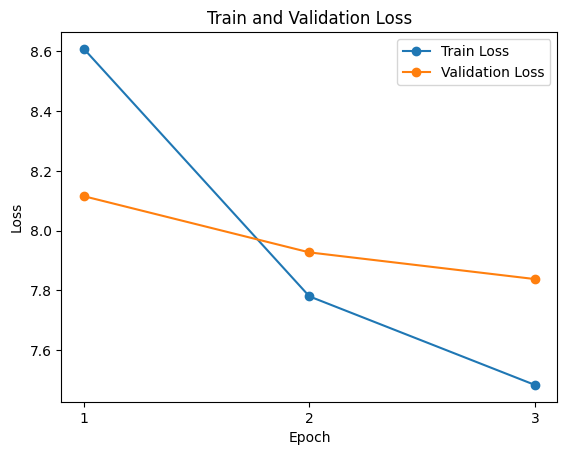

<================================================================>
Prepared data for Skip-gram for window size 1.
			Feature shapes:
Train set: 		(4736859,) 
Val set: 		(1184215,)
<================================================================>


Val epoch 3/3: 100%|██████████| 1157/1157 [00:15<00:00, 72.84it/s]


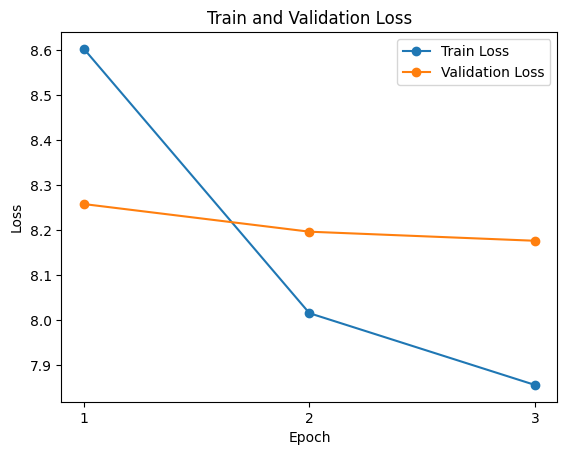

<================================================================>
Prepared data for CBOW for window size 2.
			Feature shapes:
Train set: 		(2368428, 4) 
Val set: 		(592107, 4)
<================================================================>


Val epoch 3/3: 100%|██████████| 579/579 [00:07<00:00, 74.11it/s]


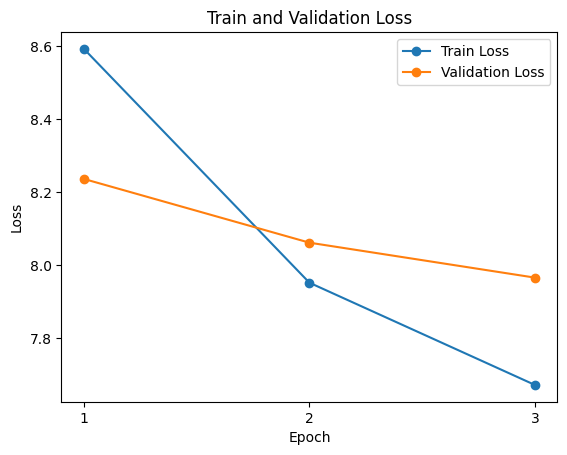

<================================================================>
Prepared data for Skip-gram for window size 2.
			Feature shapes:
Train set: 		(9473712,) 
Val set: 		(2368428,)
<================================================================>


Val epoch 3/3: 100%|██████████| 2313/2313 [00:30<00:00, 74.87it/s]


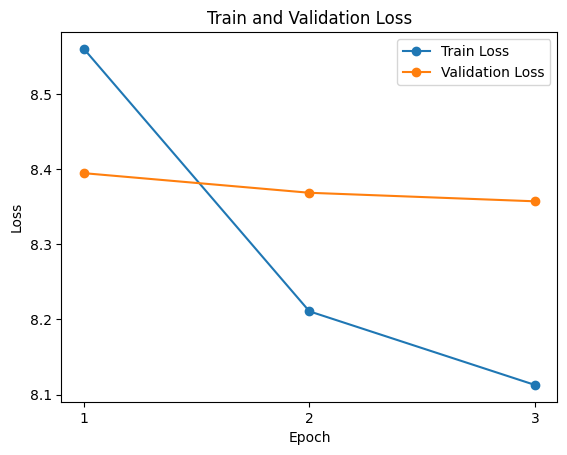

<================================================================>
Prepared data for CBOW for window size 3.
			Feature shapes:
Train set: 		(2368426, 6) 
Val set: 		(592107, 6)
<================================================================>


Val epoch 3/3: 100%|██████████| 579/579 [00:07<00:00, 72.94it/s]


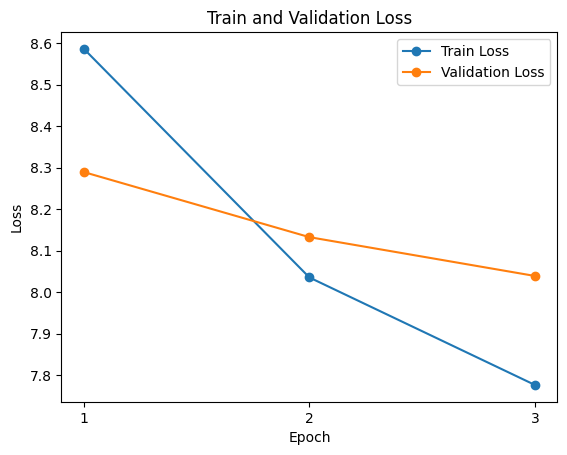

<================================================================>
Prepared data for Skip-gram for window size 3.
			Feature shapes:
Train set: 		(14210558,) 
Val set: 		(3552640,)
<================================================================>


Val epoch 3/3: 100%|██████████| 3470/3470 [00:46<00:00, 74.21it/s]


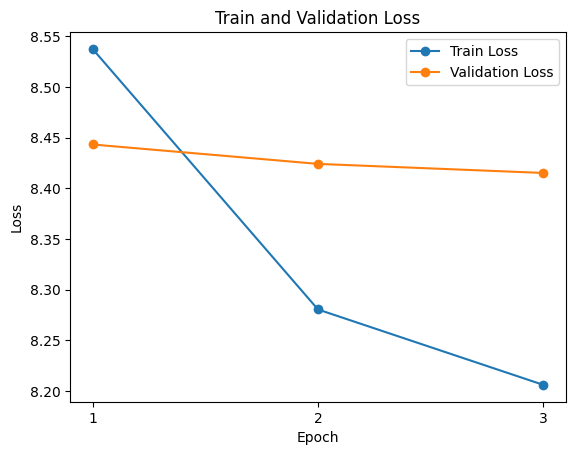

In [ ]:
vocab_size = len(vocab_to_int)
embed_dim = 100  # We will train 100-dimension embedding, the same as in Task 1 for GloVe
lr=1e-3

cbows = []
skipgrams = []
window_sizes = [1, 2, 3]
for window_size in window_sizes:

  # CBOW
  train_dataloader, val_dataloader = get_dataloaders(text_ints, window_size, context_is_target=False)
  cbow = CBOW(vocab_size, embed_dim).to(device)
  cbow_criterion = nn.CrossEntropyLoss()
  cbow_optimizer = torch.optim.Adam(cbow.parameters(), lr=lr)
  cbow = train(cbow, cbow_criterion, cbow_optimizer, train_dataloader, val_dataloader)
  cbows.append(cbow)

  # Skip-gram
  train_dataloader, val_dataloader = get_dataloaders(text_ints, window_size, context_is_target=True)
  skipgram = Skipgram(vocab_size, embed_dim).to(device)
  skipgram_criterion = nn.CrossEntropyLoss()
  skipgram_optimizer = torch.optim.Adam(skipgram.parameters(), lr=lr)
  skipgram = train(skipgram, skipgram_criterion, skipgram_optimizer, train_dataloader, val_dataloader)
  skipgrams.append(skipgram)

### Training the classifier

As we can not compare the embeddings directly, we need to train a simple classification model, which will use these embeddings as frozen first layer. The smaller the model is, the better, as in this case the embeddings will play a bigger role in predictions.

In [ ]:
class Classifier(nn.Module):
  def __init__(self, encoder, hidden_dim, num_classes):
    super().__init__()

    self.encoder = encoder  # It is already frozen

    self.head = nn.Sequential(
      nn.Linear(encoder.embedding_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, num_classes)
    )

  def forward(self, X):
    emb = self.encoder(X)

    pooled = emb.mean(dim=1)  # We won't do anything too complex in this task and will just use average pooling

    out = self.head(pooled)
    return out

#### Data preparation

We need to prepare the data for training/validating/testing the classifier.

In [ ]:
# Tokenizing and mapping to ints each record in the data
imdb_train_x_num = []
for review in imdb_train_x:
  imdb_train_x_num.append(to_ints(cleanup(review).split()))

In [ ]:
review_lens = Counter([len(x) for x in imdb_train_x_num])
print(f"Zero-length reviews: {review_lens[0]}")
print(f"Maximum review length: {max(review_lens)}")
print(f"Median review length: {median(review_lens)}")  # To understand which seq_length is better

Zero-length reviews: 0
Maximum review length: 1416
Median review length: 293


As we can see, there are no empty reviews, so we don't need to delete anything. Also, we can choose `seq_length`=400.

In [ ]:
def pad_data(docs, seq_length):
  padded_docs = []

  for doc in docs:
    if len(doc) >= seq_length:
      padded_docs.append(doc[:seq_length])
    else:
      pad_cnt = seq_length - len(doc)
      padded_review = [0] * pad_cnt + doc
      padded_docs.append(padded_review)

  return np.array(padded_docs)


seq_length = 400
padded_reviews_numbers = pad_data(imdb_train_x_num, seq_length=seq_length)

In [ ]:
def get_dataloaders_for_classifier(padded_data, labels, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, batch_size=batch_size):
  train_X, val_test_X, train_Y, val_test_Y = train_test_split(padded_data, labels, train_size=train_ratio, shuffle=False)
  val_X, test_X, val_Y, test_Y = train_test_split(val_test_X, val_test_Y, train_size=val_ratio/(val_ratio+test_ratio), shuffle=False)
  train_X, val_X, train_Y, val_Y = np.array(train_X, dtype=int), np.array(val_X, dtype=int), np.array(train_Y, dtype=int), np.array(val_Y, dtype=int)

  train_dataset = TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_Y))
  val_dataset   = TensorDataset(torch.from_numpy(val_X),   torch.from_numpy(val_Y))
  test_dataset  = TensorDataset(torch.from_numpy(test_X),  torch.from_numpy(test_Y))

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
  test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

  print("<================================================================>")
  print(f"Prepared data for Classifier.")
  print("\t\t\tFeature shapes:")
  print(f"Train set: \t\t{train_X.shape}",
        f"\nVal set: \t\t{val_X.shape}",
        f"\nTest set: \t\t{test_X.shape}")
  print("<================================================================>")

  return train_dataloader, val_dataloader, test_dataloader

In [ ]:
def train_classifier(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=10):
  for e in range(epochs):
    model.train()

    total_loss = 0.0
    for input, labels in tqdm(train_dataloader, desc=f"Train epoch {e+1}/{epochs}"):
      optimizer.zero_grad()

      input, labels = input.to(device), labels.to(device)

      output = model(input)

      loss = criterion(output.float(), labels)
      loss.backward()
      total_loss += loss.item()

      optimizer.step()

    print(f"Train loss for epoch {e+1}/{epochs}: {total_loss / len(train_dataloader)}")

    model.eval()
    with torch.no_grad():
      total_loss = 0.0
      for input, labels in tqdm(val_dataloader, desc=f"Val epoch {e+1}/{epochs}"):
        input, labels = input.to(device), labels.to(device)

        output = model(input)

        loss = criterion(output.float(), labels)
        total_loss += loss.item()

      print(f"Val loss for epoch {e+1}/{epochs}: {total_loss / len(train_dataloader)}")

  return model


def test(model, test_dataloader):
  correct = 0
  total = 0

  model.eval()
  with torch.no_grad():
    for input, labels in test_dataloader:
      input, labels = input.to(device), labels.to(device)

      output = model(input)

      probs = torch.softmax(output, dim=1)
      predicted_labels = torch.argmax(probs, dim=1)

      correct += (predicted_labels == labels).sum().item()
      total += len(labels)

  return correct/total

Finally, we can see the results of our experiment:

<================================================================>
Prepared data for Classifier.
			Feature shapes:
Train set: 		(20000, 400) 
Val set: 		(2500, 400) 
Test set: 		(2500, 400)
<================================================================>


Train epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 90.52it/s]


Train loss for epoch 1/10: 0.6929073303937912


Val epoch 1/10: 100%|██████████| 3/3 [00:00<00:00, 127.55it/s]


Val loss for epoch 1/10: 0.10351060032844543


Train epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 99.46it/s]


Train loss for epoch 2/10: 0.6881866067647934


Val epoch 2/10: 100%|██████████| 3/3 [00:00<00:00, 119.73it/s]


Val loss for epoch 2/10: 0.10268447697162628


Train epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 96.31it/s]


Train loss for epoch 3/10: 0.6828930348157882


Val epoch 3/10: 100%|██████████| 3/3 [00:00<00:00, 124.44it/s]


Val loss for epoch 3/10: 0.1016047477722168


Train epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 102.32it/s]


Train loss for epoch 4/10: 0.6751102060079575


Val epoch 4/10: 100%|██████████| 3/3 [00:00<00:00, 119.00it/s]


Val loss for epoch 4/10: 0.10036984384059906


Train epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 34.98it/s]


Train loss for epoch 5/10: 0.6689899414777756


Val epoch 5/10: 100%|██████████| 3/3 [00:00<00:00, 120.11it/s]


Val loss for epoch 5/10: 0.09896728098392486


Train epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 96.07it/s]


Train loss for epoch 6/10: 0.6597799897193909


Val epoch 6/10: 100%|██████████| 3/3 [00:00<00:00, 124.76it/s]


Val loss for epoch 6/10: 0.09775515496730805


Train epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 101.16it/s]


Train loss for epoch 7/10: 0.6518457293510437


Val epoch 7/10: 100%|██████████| 3/3 [00:00<00:00, 111.97it/s]


Val loss for epoch 7/10: 0.09634684026241302


Train epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 100.50it/s]


Train loss for epoch 8/10: 0.646383985877037


Val epoch 8/10: 100%|██████████| 3/3 [00:00<00:00, 122.62it/s]


Val loss for epoch 8/10: 0.0950238436460495


Train epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 96.47it/s]


Train loss for epoch 9/10: 0.6394307374954223


Val epoch 9/10: 100%|██████████| 3/3 [00:00<00:00, 125.45it/s]


Val loss for epoch 9/10: 0.09425971508026124


Train epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 95.33it/s]


Train loss for epoch 10/10: 0.6307956546545028


Val epoch 10/10: 100%|██████████| 3/3 [00:00<00:00, 104.45it/s]


Val loss for epoch 10/10: 0.0936756432056427


Train epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 104.68it/s]


Train loss for epoch 1/10: 0.693007954955101


Val epoch 1/10: 100%|██████████| 3/3 [00:00<00:00, 126.47it/s]


Val loss for epoch 1/10: 0.10362881124019623


Train epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 103.93it/s]


Train loss for epoch 2/10: 0.6893618017435074


Val epoch 2/10: 100%|██████████| 3/3 [00:00<00:00, 116.88it/s]


Val loss for epoch 2/10: 0.10309726893901824


Train epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 102.26it/s]


Train loss for epoch 3/10: 0.6847645372152329


Val epoch 3/10: 100%|██████████| 3/3 [00:00<00:00, 124.70it/s]


Val loss for epoch 3/10: 0.10230926871299743


Train epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 35.74it/s]


Train loss for epoch 4/10: 0.6768885165452957


Val epoch 4/10: 100%|██████████| 3/3 [00:00<00:00, 115.67it/s]


Val loss for epoch 4/10: 0.10094408690929413


Train epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 105.79it/s]


Train loss for epoch 5/10: 0.668203917145729


Val epoch 5/10: 100%|██████████| 3/3 [00:00<00:00, 115.82it/s]


Val loss for epoch 5/10: 0.09895274937152862


Train epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 102.50it/s]


Train loss for epoch 6/10: 0.6582711040973663


Val epoch 6/10: 100%|██████████| 3/3 [00:00<00:00, 127.11it/s]


Val loss for epoch 6/10: 0.09781480431556702


Train epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 104.72it/s]


Train loss for epoch 7/10: 0.6510430663824082


Val epoch 7/10: 100%|██████████| 3/3 [00:00<00:00, 125.02it/s]


Val loss for epoch 7/10: 0.09666317105293273


Train epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 100.69it/s]


Train loss for epoch 8/10: 0.6391168504953384


Val epoch 8/10: 100%|██████████| 3/3 [00:00<00:00, 119.76it/s]


Val loss for epoch 8/10: 0.09508235454559326


Train epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 105.32it/s]


Train loss for epoch 9/10: 0.6335226893424988


Val epoch 9/10: 100%|██████████| 3/3 [00:00<00:00, 130.20it/s]


Val loss for epoch 9/10: 0.09540639817714691


Train epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 101.41it/s]


Train loss for epoch 10/10: 0.6259157180786132


Val epoch 10/10: 100%|██████████| 3/3 [00:00<00:00, 121.53it/s]


Val loss for epoch 10/10: 0.0930050790309906


Train epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 99.95it/s]


Train loss for epoch 1/10: 0.6917327851057052


Val epoch 1/10: 100%|██████████| 3/3 [00:00<00:00, 129.03it/s]


Val loss for epoch 1/10: 0.10281655788421631


Train epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 96.34it/s]


Train loss for epoch 2/10: 0.6811017721891404


Val epoch 2/10: 100%|██████████| 3/3 [00:00<00:00, 132.27it/s]


Val loss for epoch 2/10: 0.10128369927406311


Train epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 103.69it/s]


Train loss for epoch 3/10: 0.6688525289297104


Val epoch 3/10: 100%|██████████| 3/3 [00:00<00:00, 115.33it/s]


Val loss for epoch 3/10: 0.09892194271087647


Train epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 36.47it/s] 


Train loss for epoch 4/10: 0.6539546906948089


Val epoch 4/10: 100%|██████████| 3/3 [00:00<00:00, 121.87it/s]


Val loss for epoch 4/10: 0.0973948895931244


Train epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 98.57it/s]


Train loss for epoch 5/10: 0.6402152746915817


Val epoch 5/10: 100%|██████████| 3/3 [00:00<00:00, 120.96it/s]


Val loss for epoch 5/10: 0.09502221643924713


Train epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 102.94it/s]


Train loss for epoch 6/10: 0.6263485699892044


Val epoch 6/10: 100%|██████████| 3/3 [00:00<00:00, 119.49it/s]


Val loss for epoch 6/10: 0.09228583872318268


Train epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 100.59it/s]


Train loss for epoch 7/10: 0.6159766882658004


Val epoch 7/10: 100%|██████████| 3/3 [00:00<00:00, 118.98it/s]


Val loss for epoch 7/10: 0.090596142411232


Train epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 101.22it/s]


Train loss for epoch 8/10: 0.6053025215864182


Val epoch 8/10: 100%|██████████| 3/3 [00:00<00:00, 107.93it/s]


Val loss for epoch 8/10: 0.08983317911624908


Train epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 100.84it/s]


Train loss for epoch 9/10: 0.5975044012069702


Val epoch 9/10: 100%|██████████| 3/3 [00:00<00:00, 96.69it/s]


Val loss for epoch 9/10: 0.08880142271518707


Train epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 94.64it/s] 


Train loss for epoch 10/10: 0.5910807728767395


Val epoch 10/10: 100%|██████████| 3/3 [00:00<00:00, 89.40it/s]


Val loss for epoch 10/10: 0.08707545399665832


Train epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 72.80it/s]


Train loss for epoch 1/10: 0.6917418330907822


Val epoch 1/10: 100%|██████████| 3/3 [00:00<00:00, 80.51it/s]


Val loss for epoch 1/10: 0.1032689481973648


Train epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 73.91it/s]


Train loss for epoch 2/10: 0.6852999359369278


Val epoch 2/10: 100%|██████████| 3/3 [00:00<00:00, 83.47it/s]


Val loss for epoch 2/10: 0.10207709670066833


Train epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 72.15it/s]


Train loss for epoch 3/10: 0.6738425701856613


Val epoch 3/10: 100%|██████████| 3/3 [00:00<00:00, 88.70it/s]


Val loss for epoch 3/10: 0.09967939555644989


Train epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 27.44it/s]


Train loss for epoch 4/10: 0.6560833930969239


Val epoch 4/10: 100%|██████████| 3/3 [00:00<00:00, 93.19it/s]


Val loss for epoch 4/10: 0.09634172320365905


Train epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 70.59it/s]


Train loss for epoch 5/10: 0.6366376847028732


Val epoch 5/10: 100%|██████████| 3/3 [00:00<00:00, 98.63it/s]


Val loss for epoch 5/10: 0.09412325918674469


Train epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 103.16it/s]


Train loss for epoch 6/10: 0.6233339935541153


Val epoch 6/10: 100%|██████████| 3/3 [00:00<00:00, 112.63it/s]


Val loss for epoch 6/10: 0.09110971689224243


Train epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 106.49it/s]


Train loss for epoch 7/10: 0.6062289088964462


Val epoch 7/10: 100%|██████████| 3/3 [00:00<00:00, 117.93it/s]


Val loss for epoch 7/10: 0.08901164531707764


Train epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 105.14it/s]


Train loss for epoch 8/10: 0.5964424997568131


Val epoch 8/10: 100%|██████████| 3/3 [00:00<00:00, 118.41it/s]


Val loss for epoch 8/10: 0.0884317547082901


Train epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 98.78it/s]


Train loss for epoch 9/10: 0.587548378109932


Val epoch 9/10: 100%|██████████| 3/3 [00:00<00:00, 133.11it/s]


Val loss for epoch 9/10: 0.08635610342025757


Train epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 101.65it/s]


Train loss for epoch 10/10: 0.5855573147535325


Val epoch 10/10: 100%|██████████| 3/3 [00:00<00:00, 113.29it/s]


Val loss for epoch 10/10: 0.0854699969291687


Train epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 103.58it/s]


Train loss for epoch 1/10: 0.6989607810974121


Val epoch 1/10: 100%|██████████| 3/3 [00:00<00:00, 113.13it/s]


Val loss for epoch 1/10: 0.10364695787429809


Train epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 104.95it/s]


Train loss for epoch 2/10: 0.6870709776878356


Val epoch 2/10: 100%|██████████| 3/3 [00:00<00:00, 114.55it/s]


Val loss for epoch 2/10: 0.10202310383319854


Train epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 99.11it/s] 


Train loss for epoch 3/10: 0.6749134838581086


Val epoch 3/10: 100%|██████████| 3/3 [00:00<00:00, 118.89it/s]


Val loss for epoch 3/10: 0.09971542954444886


Train epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 36.60it/s]


Train loss for epoch 4/10: 0.6586803734302521


Val epoch 4/10: 100%|██████████| 3/3 [00:00<00:00, 116.39it/s]


Val loss for epoch 4/10: 0.09700371325016022


Train epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 100.59it/s]


Train loss for epoch 5/10: 0.6416888535022736


Val epoch 5/10: 100%|██████████| 3/3 [00:00<00:00, 106.21it/s]


Val loss for epoch 5/10: 0.09439594149589539


Train epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 96.74it/s]


Train loss for epoch 6/10: 0.6263033509254455


Val epoch 6/10: 100%|██████████| 3/3 [00:00<00:00, 115.46it/s]


Val loss for epoch 6/10: 0.09108101427555085


Train epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 101.50it/s]


Train loss for epoch 7/10: 0.6081293195486068


Val epoch 7/10: 100%|██████████| 3/3 [00:00<00:00, 116.84it/s]


Val loss for epoch 7/10: 0.08919243812561035


Train epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 103.81it/s]


Train loss for epoch 8/10: 0.5978127092123031


Val epoch 8/10: 100%|██████████| 3/3 [00:00<00:00, 126.67it/s]


Val loss for epoch 8/10: 0.08777829706668853


Train epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 102.62it/s]


Train loss for epoch 9/10: 0.5902859508991242


Val epoch 9/10: 100%|██████████| 3/3 [00:00<00:00, 100.17it/s]


Val loss for epoch 9/10: 0.08562549054622651


Train epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 102.46it/s]


Train loss for epoch 10/10: 0.5812894642353058


Val epoch 10/10: 100%|██████████| 3/3 [00:00<00:00, 113.92it/s]


Val loss for epoch 10/10: 0.08600079715251922


Train epoch 1/10: 100%|██████████| 20/20 [00:00<00:00, 101.32it/s]


Train loss for epoch 1/10: 0.6904224723577499


Val epoch 1/10: 100%|██████████| 3/3 [00:00<00:00, 109.10it/s]


Val loss for epoch 1/10: 0.10306061208248138


Train epoch 2/10: 100%|██████████| 20/20 [00:00<00:00, 101.75it/s]


Train loss for epoch 2/10: 0.6801281452178956


Val epoch 2/10: 100%|██████████| 3/3 [00:00<00:00, 115.80it/s]


Val loss for epoch 2/10: 0.10082825422286987


Train epoch 3/10: 100%|██████████| 20/20 [00:00<00:00, 35.49it/s] 


Train loss for epoch 3/10: 0.6643574893474579


Val epoch 3/10: 100%|██████████| 3/3 [00:00<00:00, 102.06it/s]


Val loss for epoch 3/10: 0.09783930182456971


Train epoch 4/10: 100%|██████████| 20/20 [00:00<00:00, 101.42it/s]


Train loss for epoch 4/10: 0.6424180716276169


Val epoch 4/10: 100%|██████████| 3/3 [00:00<00:00, 117.67it/s]


Val loss for epoch 4/10: 0.09446047842502595


Train epoch 5/10: 100%|██████████| 20/20 [00:00<00:00, 93.50it/s]


Train loss for epoch 5/10: 0.620315408706665


Val epoch 5/10: 100%|██████████| 3/3 [00:00<00:00, 103.67it/s]


Val loss for epoch 5/10: 0.09287220537662506


Train epoch 6/10: 100%|██████████| 20/20 [00:00<00:00, 98.53it/s]


Train loss for epoch 6/10: 0.6040408223867416


Val epoch 6/10: 100%|██████████| 3/3 [00:00<00:00, 117.98it/s]


Val loss for epoch 6/10: 0.08850703239440919


Train epoch 7/10: 100%|██████████| 20/20 [00:00<00:00, 103.45it/s]


Train loss for epoch 7/10: 0.5920562446117401


Val epoch 7/10: 100%|██████████| 3/3 [00:00<00:00, 118.18it/s]


Val loss for epoch 7/10: 0.08658568859100342


Train epoch 8/10: 100%|██████████| 20/20 [00:00<00:00, 97.07it/s]


Train loss for epoch 8/10: 0.5813541084527969


Val epoch 8/10: 100%|██████████| 3/3 [00:00<00:00, 111.65it/s]


Val loss for epoch 8/10: 0.08616225123405456


Train epoch 9/10: 100%|██████████| 20/20 [00:00<00:00, 98.19it/s]


Train loss for epoch 9/10: 0.5727183490991592


Val epoch 9/10: 100%|██████████| 3/3 [00:00<00:00, 100.36it/s]


Val loss for epoch 9/10: 0.08527563214302063


Train epoch 10/10: 100%|██████████| 20/20 [00:00<00:00, 103.32it/s]


Train loss for epoch 10/10: 0.5634459465742111


Val epoch 10/10: 100%|██████████| 3/3 [00:00<00:00, 121.43it/s]


Val loss for epoch 10/10: 0.08329688012599945


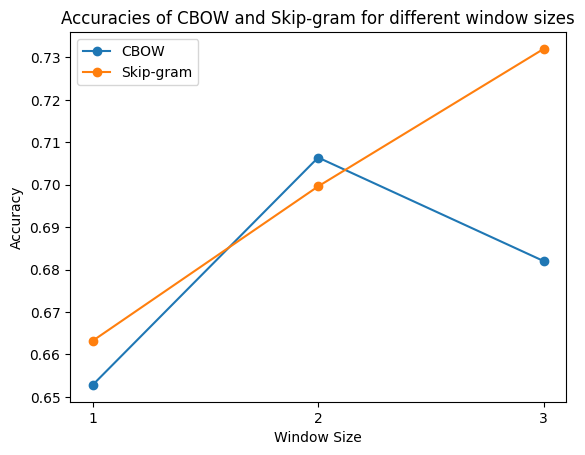

In [ ]:
hidden_dim = 100
lr = 1e-3
num_classes = 2
cbow_accs = []
skipgram_accs = []
window_sizes = []

train_dataloader, val_dataloader, test_dataloader = get_dataloaders_for_classifier(padded_reviews_numbers, imdb_train_y)

plt.ion()
fig, ax = plt.subplots()

w = 1
for cbow, skipgram in zip(cbows, skipgrams):

  # CBOW
  pretrained_matrix_cbow = cbow.get_embeddings()
  cbow_encoder = nn.Embedding.from_pretrained(pretrained_matrix_cbow, freeze=True)

  cbow_classifier = Classifier(cbow_encoder, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
  cbow_criterion = nn.CrossEntropyLoss()
  cbow_optimizer = torch.optim.Adam(cbow_classifier.parameters(), lr=lr)

  cbow_classifier = train_classifier(cbow_classifier, cbow_criterion, cbow_optimizer, train_dataloader, val_dataloader)
  cbow_acc = test(cbow_classifier, test_dataloader)
  cbow_accs.append(cbow_acc)

  # Skip-gram
  pretrained_matrix_skipgram = skipgram.get_embeddings()
  skipgram_encoder = nn.Embedding.from_pretrained(pretrained_matrix_skipgram, freeze=True)

  skipgram_classifier = Classifier(skipgram_encoder, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
  skipgram_criterion = nn.CrossEntropyLoss()
  skipgram_optimizer = torch.optim.Adam(skipgram_classifier.parameters(), lr=lr)

  skipgram_classifier = train_classifier(skipgram_classifier, skipgram_criterion, skipgram_optimizer, train_dataloader, val_dataloader)
  skipgram_acc = test(skipgram_classifier, test_dataloader)
  skipgram_accs.append(skipgram_acc)

  # Display stats
  window_sizes.append(w)
  ax.clear()
  ax.plot(window_sizes, cbow_accs, marker="o", label="CBOW")
  ax.plot(window_sizes, skipgram_accs, marker="o", label="Skip-gram")
  ax.set_xticks(window_sizes)
  ax.set_xlabel("Window Size")
  ax.set_ylabel("Accuracy")
  ax.set_title("Accuracies of CBOW and Skip-gram for different window sizes")
  ax.legend()

  w += 1

plt.ioff()
plt.show()

### Conclusion

In conclusion, one needs to take into account that our mapping to centre word and context isn't perfect: we joined the whole data into one string, so some words from the end of the previous review appear in the context of the words from the beginning of the currect review.

**Results of experiments:**
- Skip-gram overfits quicker than CBOW
- The model with CBOW with `window_size=2` yielded a better score than the one with Skip-gram
- In the end, we can see that Skip-gram produced a better word representation with `window_size=3`, as the model's accuracy is higher than for the model with CBOW